In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
import torch
import torch.nn as nn

In [1]:
from torchvision.datasets import MNIST
imporat torchvision.transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

SyntaxError: invalid syntax (4216659165.py, line 2)

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import autoguide, SVI, Trace_ELBO, Predictive

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [ ]:
# Set the device
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Get Data

In [4]:
train_data = MNIST(root="lab4_data", train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = MNIST(root="lab4_data", train=False, download=True, transform=torchvision.transforms.ToTensor())

# Make data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

# Define a simple neural network

A lot has changed since the tutorial was made. To make this model, I used the following additional resources:
* [Bayesian Regression - Introduction (Part 1)](http://pyro.ai/examples/bayesian_regression.html)
* [Tensor shapes in Pyro](https://pyro.ai/examples/tensor_shapes.html)
* [Tutorial Github](https://github.com/paraschopra/bayesian-neural-network-mnist/blob/master/bnn.ipynb)

In [5]:
class BayesianLinearModel(PyroModule):
    def __init__(self, hidden_dim=1024, num_classes=10):
        super().__init__()
        # Define the layers
        self.linear1 = PyroModule[nn.Linear](784, hidden_dim)
        self.linear2 = PyroModule[nn.Linear](hidden_dim, num_classes)

        # Set priors over the weights
        self.linear1.weight = PyroSample(dist.Normal(0., 1.).expand([hidden_dim, 784]).to_event(2))
        self.linear1.bias = PyroSample(dist.Normal(0., 10.).expand([hidden_dim]).to_event(1))
        self.linear2.weight = PyroSample(dist.Normal(0., 1.).expand([num_classes, hidden_dim]).to_event(2))
        self.linear2.bias = PyroSample(dist.Normal(0., 10.).expand([num_classes]).to_event(1))

        # Define the activation function
        self.relu = nn.ReLU()
    
    def forward(self, x, y=None):
        # Define the forward pass
        x = x.reshape(-1, 784)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        # Define the loss function
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)
        # Return the logits
        return x


In [6]:
# Instantiate the model and the guide
model = BayesianLinearModel()
guide = autoguide.AutoDiagonalNormal(model)

The guide that I'm using is the same as the one in the tutorial, but Pyro has made it much easier with the introduction of `AutoGuide` objects.
In the tutorial, the author specifies the variational distributions. In the newer version of Pyro, we can use the AutoDiagonalNormal object to automatically create the variational distributions for us.

In [7]:
adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

# Train

In [8]:
num_epochs = 20
for epoch in range(num_epochs):
    # Training
    model.train()
    avg_loss = 0
    for x, y in train_loader:
        # Set the data to the device
        # x = x.to(device)
        # y = y.to(device)
        # Perform one step of SVI
        loss = svi.step(x, y)
        avg_loss += loss / len(train_loader)
    print(f"Epoch: {epoch}, Loss: {avg_loss}")
    

Epoch: 0, Loss: 393567.85140413704
Epoch: 1, Loss: 16225.279364677388
Epoch: 2, Loss: 14005.56962425215
Epoch: 3, Loss: 13067.074910584812
Epoch: 4, Loss: 12638.770617942575
Epoch: 5, Loss: 12123.513946769084
Epoch: 6, Loss: 11812.425219676144
Epoch: 7, Loss: 11540.372253613175
Epoch: 8, Loss: 11409.781646525182
Epoch: 9, Loss: 11066.059689064272
Epoch: 10, Loss: 10988.23308612849
Epoch: 11, Loss: 10755.10146843396
Epoch: 12, Loss: 10683.949745893986
Epoch: 13, Loss: 10505.830748137134
Epoch: 14, Loss: 10384.637019021162
Epoch: 15, Loss: 10289.744211200974
Epoch: 16, Loss: 10228.473856521308
Epoch: 17, Loss: 10066.261817492907
Epoch: 18, Loss: 9924.813015187478
Epoch: 19, Loss: 9883.513972024166


# Prediction

In [9]:
num_samples = 100
predictive = Predictive(model, guide=guide, num_samples=num_samples, return_sites=("obs", "_RETURN"))

In [10]:
model.eval()
test_predictive_distributions = []
for x, y in test_loader:
    # Set the data to the device
    # x = x.to(device)
    # y = y.to(device)
    # Get the predictions
    predictions = predictive(x)
    test_predictive_distributions.append(predictions["obs"].numpy().transpose(1, 0))

test_predictive_distributions = np.concatenate(test_predictive_distributions, axis=0)

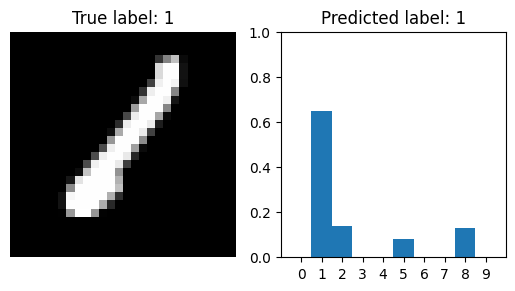

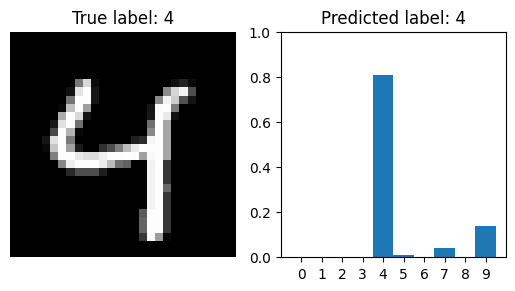

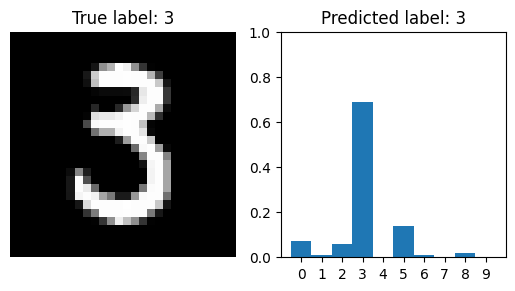

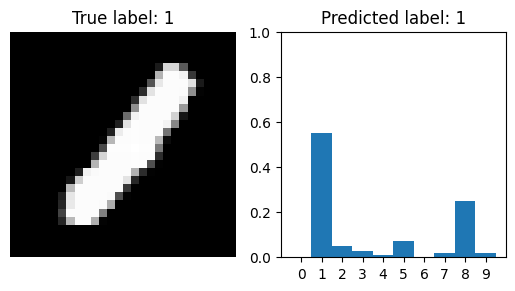

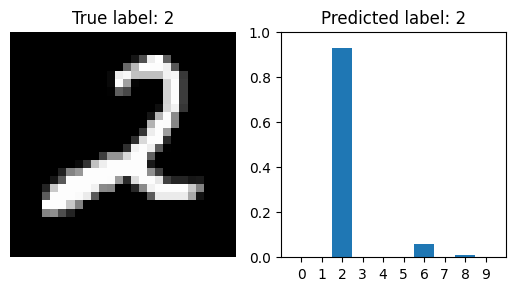

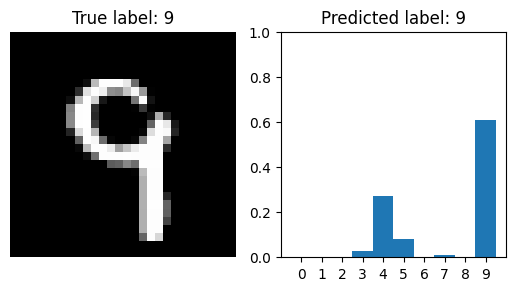

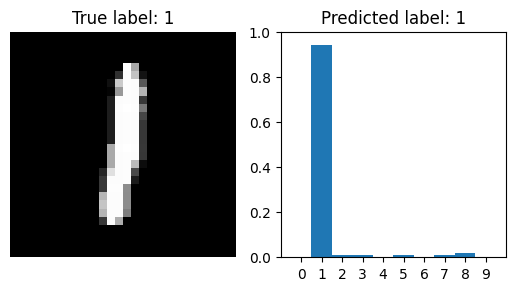

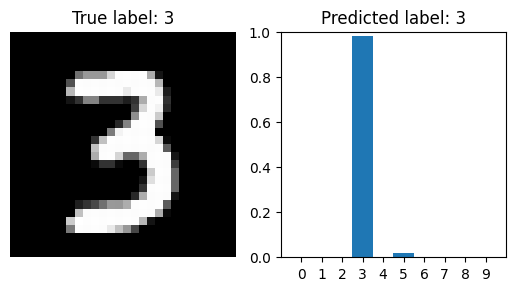

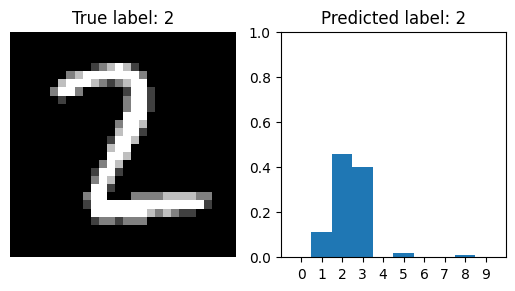

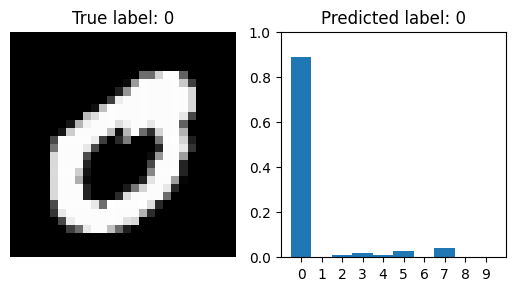

In [11]:
def get_prediction(dist, threshold=.3):
    # Get the mode of the distribution
    mode, n = scipy.stats.mode(dist, keepdims=False)
    # Get the probability of the mode
    prob = n / len(dist)
    # If the probability is above the threshold, return the mode
    if prob > threshold:
        return mode
    # Otherwise, return None
    else:
        return None
    
def plot_prediction(i, dists, test_data, threshold=.3, show_true_label=True):
    fig, ax = plt.subplots(1, 2)
    prediction = get_prediction(dists[i], threshold)
    if prediction is None:
        prediction = "Uncertain"
    true_label = test_data[i][1]
    image = test_data[i][0].reshape(28, 28)

    ax[1].hist(dists[i], bins=np.arange(11)-0.5, density=True)
    ax[1].set_xticks(range(10))
    ax[1].set_title(f"Predicted label: {prediction}")
    ax[1].set_box_aspect(1)
    ax[1].set_ylim(0, 1)
    ax[0].imshow(image, cmap="gray")
    if show_true_label:
        ax[0].set_title(f"True label: {true_label}")
    ax[0].axis("off")
    plt.show()

for i in np.random.choice(len(test_data), 10, replace=False):
    plot_prediction(i, test_predictive_distributions, test_data)

In [12]:
# Generate random data
model.eval()
rand_data = []
rand_predictive_distributions = []
for _ in range(10):
    x = torch.randn(128, 1, 28, 28)
    y = torch.randint(0, 10, (128,))
    # Set the data to the device
    # x = x.to(device)
    # y = y.to(device)
    # Get the predictions
    predictions = predictive(x)
    rand_data.extend(list(zip(x, y)))
    rand_predictive_distributions.append(predictions["obs"].numpy().transpose(1, 0))

rand_predictive_distributions = np.concatenate(rand_predictive_distributions, axis=0)

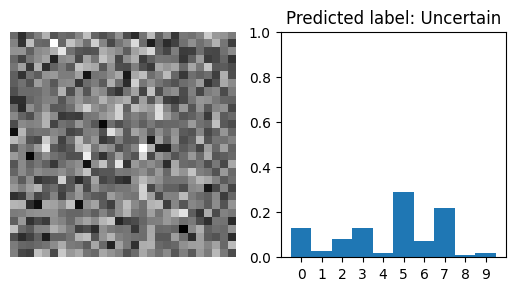

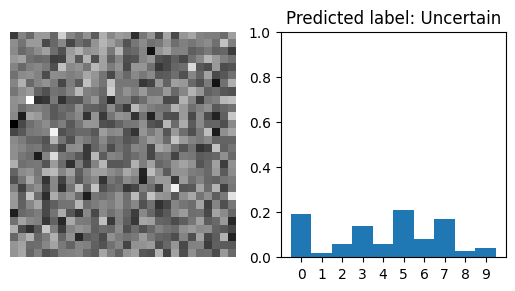

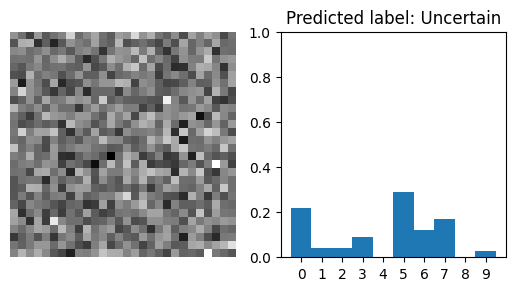

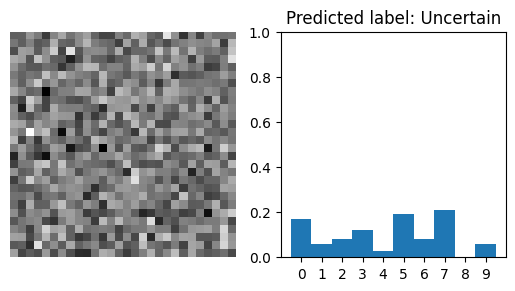

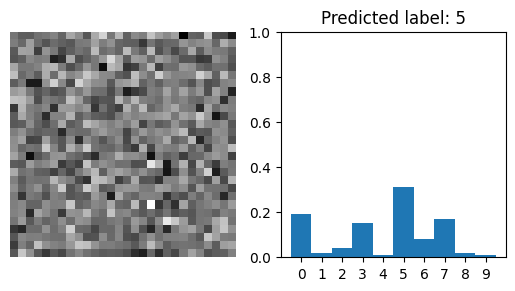

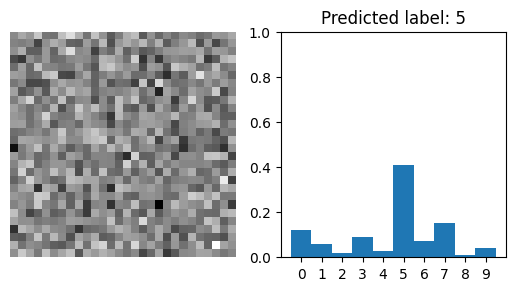

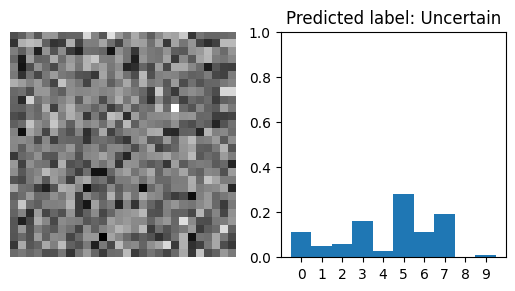

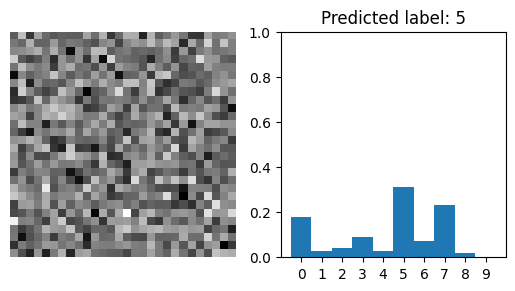

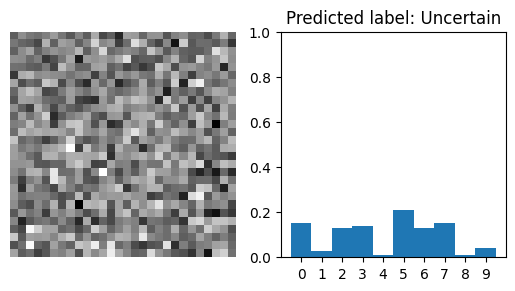

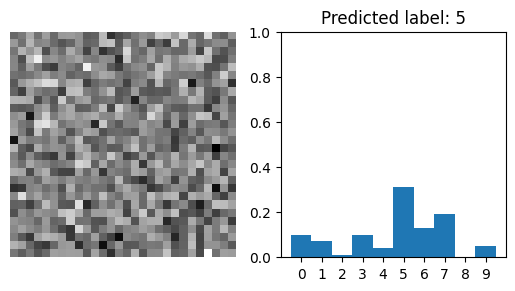

In [13]:
for i in range(10):
    plot_prediction(i, rand_predictive_distributions, rand_data, show_true_label=False)

# Evaluate

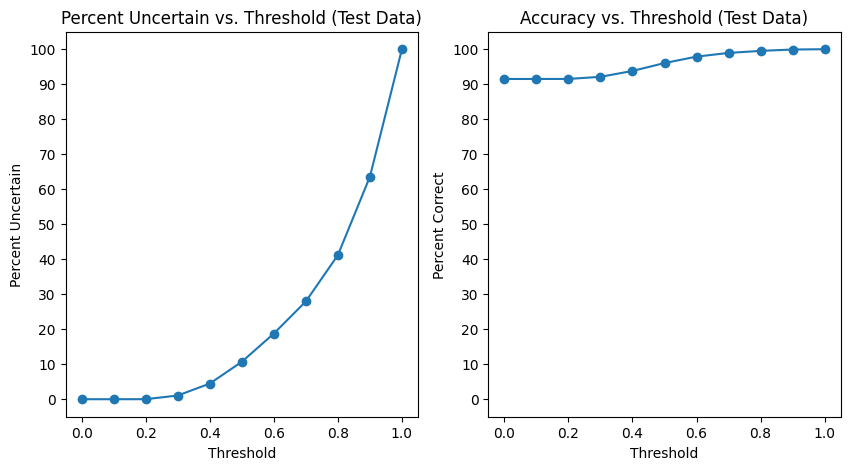

In [14]:
# What percent of the predictions are uncertain?
thresholds = np.linspace(0, 1, 11)
accuracy = np.zeros_like(thresholds)
num_predictions = np.zeros_like(thresholds)
for i in range(len(test_predictive_distributions)):
    dist = test_predictive_distributions[i]
    for j, threshold in enumerate(thresholds):
        prediction = get_prediction(dist, threshold)
        if prediction is not None:
            num_predictions[j] += 1
            if prediction == test_data[i][1]:
                accuracy[j] += 1

accuracy[num_predictions > 0] = accuracy[num_predictions > 0] / num_predictions[num_predictions > 0]
accuracy[num_predictions == 0] = 1
uncertain = 1 - (num_predictions / len(test_data))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(thresholds, uncertain*100, marker="o")
ax[0].set_xlabel("Threshold")
ax[0].set_ylabel("Percent Uncertain")
ax[0].set_title("Percent Uncertain vs. Threshold (Test Data)")
ax[0].set_yticks(np.linspace(0, 100, 11))

ax[1].plot(thresholds, accuracy*100, marker="o")
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Percent Correct")
ax[1].set_title("Accuracy vs. Threshold (Test Data)")
ax[1].set_yticks(np.linspace(0, 100, 11))
ax[1].set_ylim(ax[0].get_ylim())

plt.show()


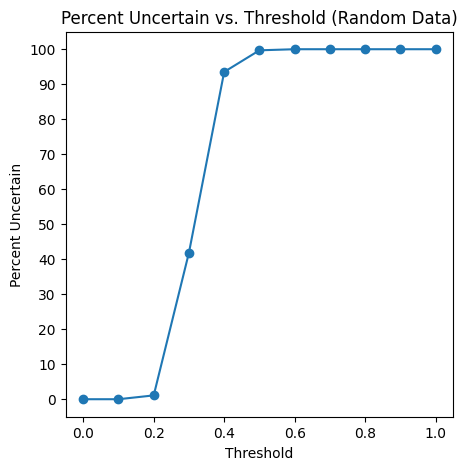

In [15]:
# What percent of the predictions are uncertain?
thresholds = np.linspace(0, 1, 11)
num_predictions = np.zeros_like(thresholds)
for i in range(len(rand_predictive_distributions)):
    dist = rand_predictive_distributions[i]
    for j, threshold in enumerate(thresholds):
        prediction = get_prediction(dist, threshold)
        if prediction is not None:
            num_predictions[j] += 1

uncertain = 1 - (num_predictions / len(rand_data))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(thresholds, uncertain*100, marker="o")
ax.set_xlabel("Threshold")
ax.set_ylabel("Percent Uncertain")
ax.set_title("Percent Uncertain vs. Threshold (Random Data)")
ax.set_yticks(np.linspace(0, 100, 11))

plt.show()

# Order by uncertainty

To measure uncertainty, I am calculating the Shannon entropy $\mathbb{E}[-\log(P)]$ of the predicted distribution. The higher the entropy, the more "spread out" the distribution is and hence the more uncertain the model is about the prediction.

In [16]:
# Now, order the predictions by certainty
def calc_entropy(dist):
    return np.mean(-np.log((np.histogram(dist, bins=np.arange(11)-0.5)[0] + 1)/111)) # +1 so that no bin is 0

In [17]:
test_entropies = []
for i in range(len(test_predictive_distributions)):
    dist = test_predictive_distributions[i]
    entropy = calc_entropy(dist)
    test_entropies.append(entropy)

test_entropies = np.array(test_entropies)

In [18]:
top_10_certain = np.argsort(test_entropies)[-10:]
top_10_uncertain = np.argsort(test_entropies)[:10]

## Top 10 most certain predictions

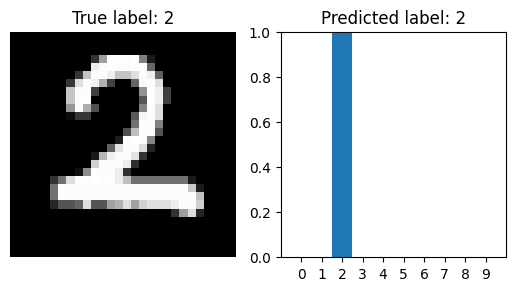

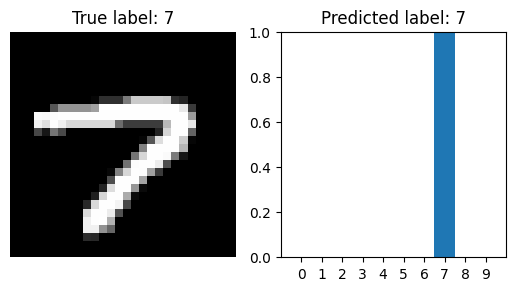

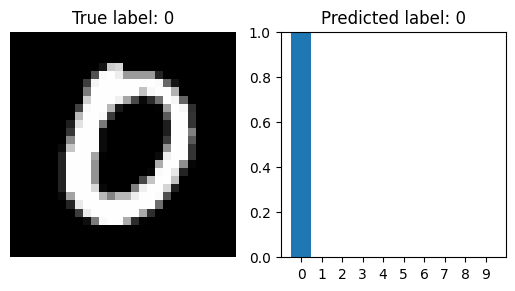

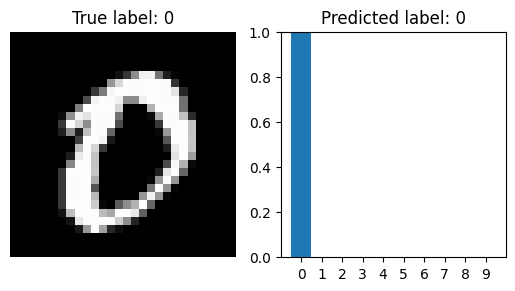

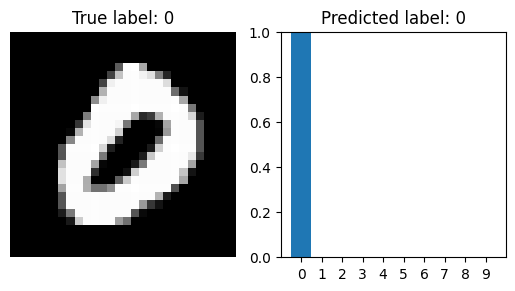

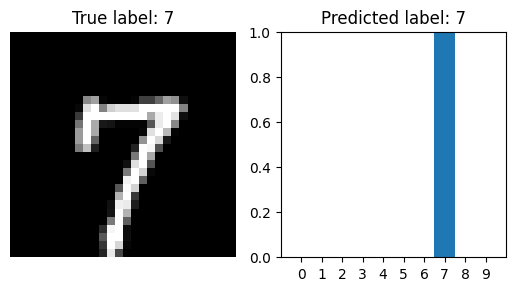

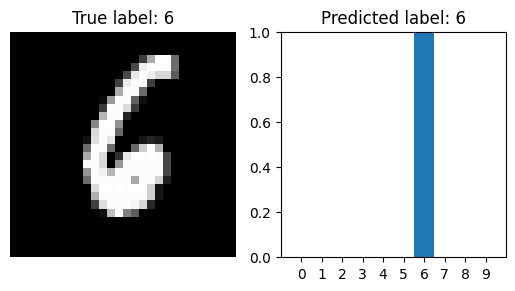

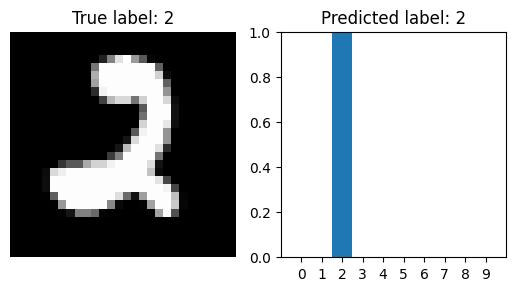

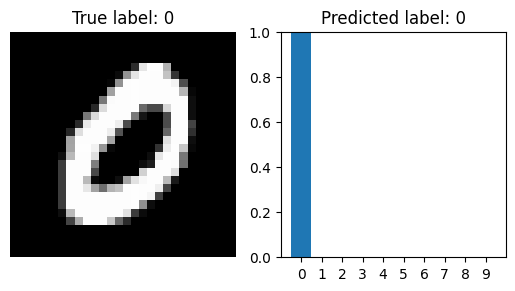

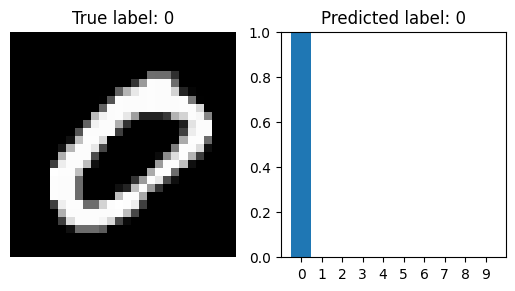

In [19]:
for idx in top_10_certain:
    plot_prediction(idx, test_predictive_distributions, test_data)

## Top 10 most uncertain predictions

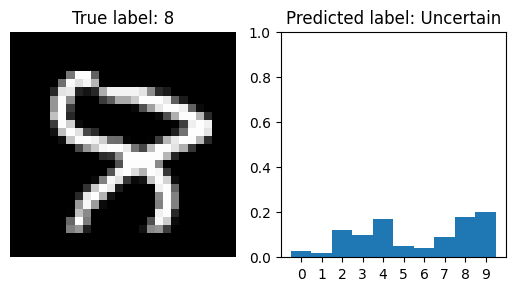

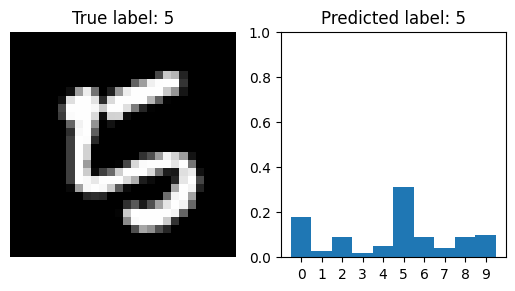

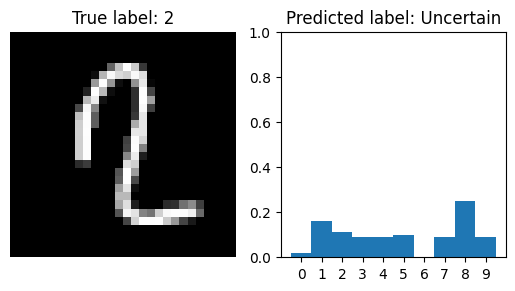

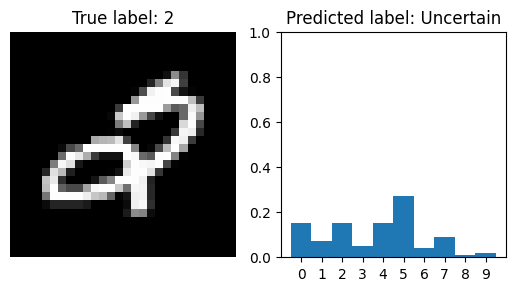

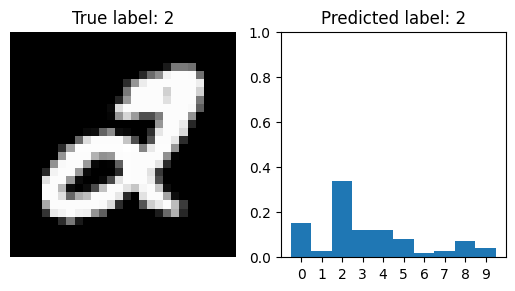

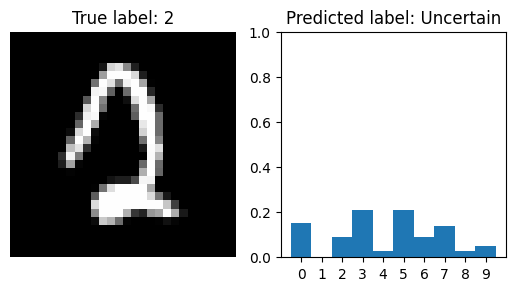

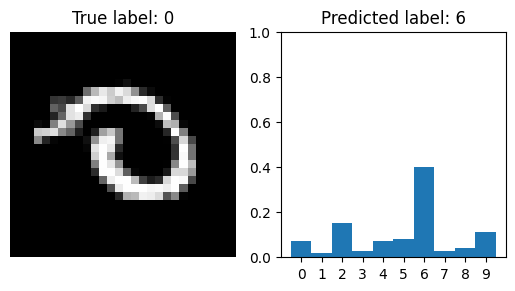

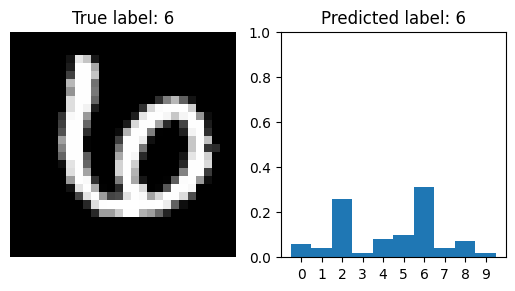

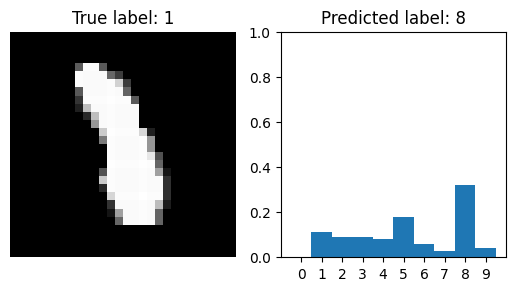

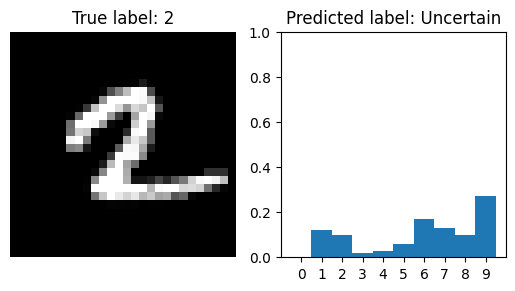

In [20]:
for idx in top_10_uncertain:
    plot_prediction(idx, test_predictive_distributions, test_data)